In [1]:
#%pip install segmentation-models keras tensorflow

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.layers import (
    Input,
    Conv2D, 
    MaxPooling2D, 
    UpSampling2D, 
    concatenate, 
    Conv2DTranspose, 
    BatchNormalization, 
    Dropout, 
    Lambda
)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import segmentation_models as sm

# https://www.kaggle.com/code/rostekus/deepglobe-land-cover-classification
# https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
# https://stochastic-thoughts.notion.site/Spatial-data-Vision-d1dbb03c40f64699a00e9106a068580e
# https://github.com/qubvel/segmentation_models

Segmentation Models: using `keras` framework.


In [3]:
IMAGE_SIZE = 320
BATCH_SIZE = 16
EPOCHS = 5

class_dict = pd.read_csv('../data/deepglobe/class_dict.csv')
num_classes = len(class_dict)
CLASSES = class_dict["name"]

colors = []
for (r,g,b) in class_dict[['r', 'g', 'b']].to_numpy():
    colors.append([r,g,b])

map_color = {x:v for x,v in zip(range(num_classes),colors)}

class_dict

,name,r,g,b
0,urban_land,0,255,255
1,agriculture_land,255,255,0
2,rangeland,255,0,255
3,forest_land,0,255,0
4,water,0,0,255
5,barren_land,255,255,255
6,unknown,0,0,0


In [4]:
df_dataset = pd.DataFrame({
    'image': sorted(glob("../data/deepglobe/train/*.jpg")), 
    'mask': sorted(glob("../data/deepglobe/train/*.png"))
})
df_dataset.head()

,image,mask
0,../data/deepglobe/train/100694_sat.jpg,../data/deepglobe/train/100694_mask.png
1,../data/deepglobe/train/102122_sat.jpg,../data/deepglobe/train/102122_mask.png
2,../data/deepglobe/train/10233_sat.jpg,../data/deepglobe/train/10233_mask.png
3,../data/deepglobe/train/103665_sat.jpg,../data/deepglobe/train/103665_mask.png
4,../data/deepglobe/train/103730_sat.jpg,../data/deepglobe/train/103730_mask.png


In [5]:
df_train, df_test = train_test_split(df_dataset, test_size=0.25, random_state=0)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=0)

print("Training set size:", len(df_train))
print("Validation set size:", len(df_val))
print("Testing set size:", len(df_test))

Training set size: 481
Validation set size: 121
Testing set size: 201


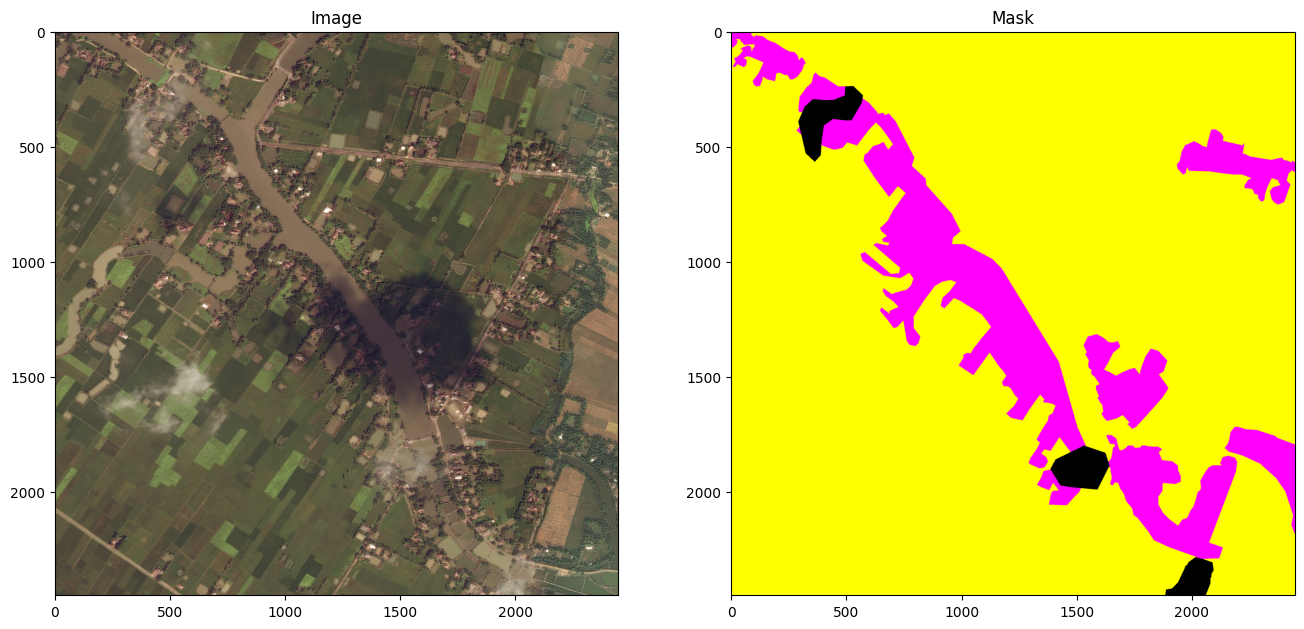

In [6]:
index = 200

sample_img = cv2.imread(df_train["image"].iloc[index])
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

sample_msk = cv2.imread(df_train["mask"].iloc[index])
sample_msk = cv2.cvtColor(sample_msk, cv2.COLOR_BGR2RGB)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

ax1.set_title('Image')
ax1.imshow(sample_img)

ax2.set_title('Mask')
ax2.imshow(sample_msk)

In [7]:
def rgb_to_onehot(rgb_arr):
    color_dict= map_color
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2]+(num_classes,)
    arr = np.zeros( shape, dtype=np.int8 )
    for i, cls_ in enumerate(color_dict):
        arr[:,:,i] = np.all(rgb_arr.reshape( (-1,3) ) == color_dict[i], axis=1).reshape(shape[:2])
    return arr

def preprocess_data_rgb_to_onehot(img, mask, num_class=7):
    scaler = MinMaxScaler()
    masks = np.zeros((mask.shape[0], 256, 256,7))
    for i ,m in enumerate(mask):
        masks[i] =rgb_to_onehot(m)      
        img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    return (img,masks)

def onehot_to_rgb(onehot, color_dict= map_color):
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in color_dict.keys():
        output[single_layer==k] = color_dict[k]
    return np.uint8(output)

In [8]:
seed=0

def data_generator(num_class=7):
    img_data_gen_args = dict(
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect'
    )
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args )

    image_train_generator = image_datagen.flow_from_dataframe(
        dataframe = df_train,
        train_dir=None,
        x_col="image",
        batch_size=BATCH_SIZE,
        seed=seed,
        class_mode = None
    )
    
    mask_train_generator = mask_datagen.flow_from_dataframe(
        dataframe = df_train,
        train_dir=None,
        x_col="mask",
        batch_size=BATCH_SIZE,
        seed=seed,
        class_mode = None
    )
    
    image_valid_generator = mask_datagen.flow_from_dataframe(
        dataframe = df_val,
        train_dir=None,
        x_col="image",
        batch_size=BATCH_SIZE,
        seed=seed,
        class_mode = None,
        validate_filenames=False
    ) 

    mask_valid_generator = image_datagen.flow_from_dataframe(
        dataframe = df_val,
        train_dir=None,
        x_col="mask",
        batch_size=BATCH_SIZE,
        seed=seed,
        class_mode = None,
        validate_filenames=False
    )
      
    train_generator= zip(image_train_generator,mask_train_generator)
    valid_generator = zip(image_valid_generator, mask_valid_generator)
    return(train_generator,valid_generator)

In [9]:
def transform_generator(gen):
    for (img, mask) in gen:
        before = (img.shape, mask.shape)
        img, mask = preprocess_data_rgb_to_onehot(img, mask)
        yield (img, mask)
        
def train_valid_gen(num_class=7):
    train_gen,valid_gen = data_generator(num_class=num_class)
    train_gen = transform_generator(train_gen)
    valid_gen = transform_generator(valid_gen)
    return (train_gen,valid_gen)

In [10]:
t, v = train_valid_gen(num_classes)

Found 481 validated image filenames.
Found 481 validated image filenames.
Found 121 non-validated image filenames.
Found 121 non-validated image filenames.


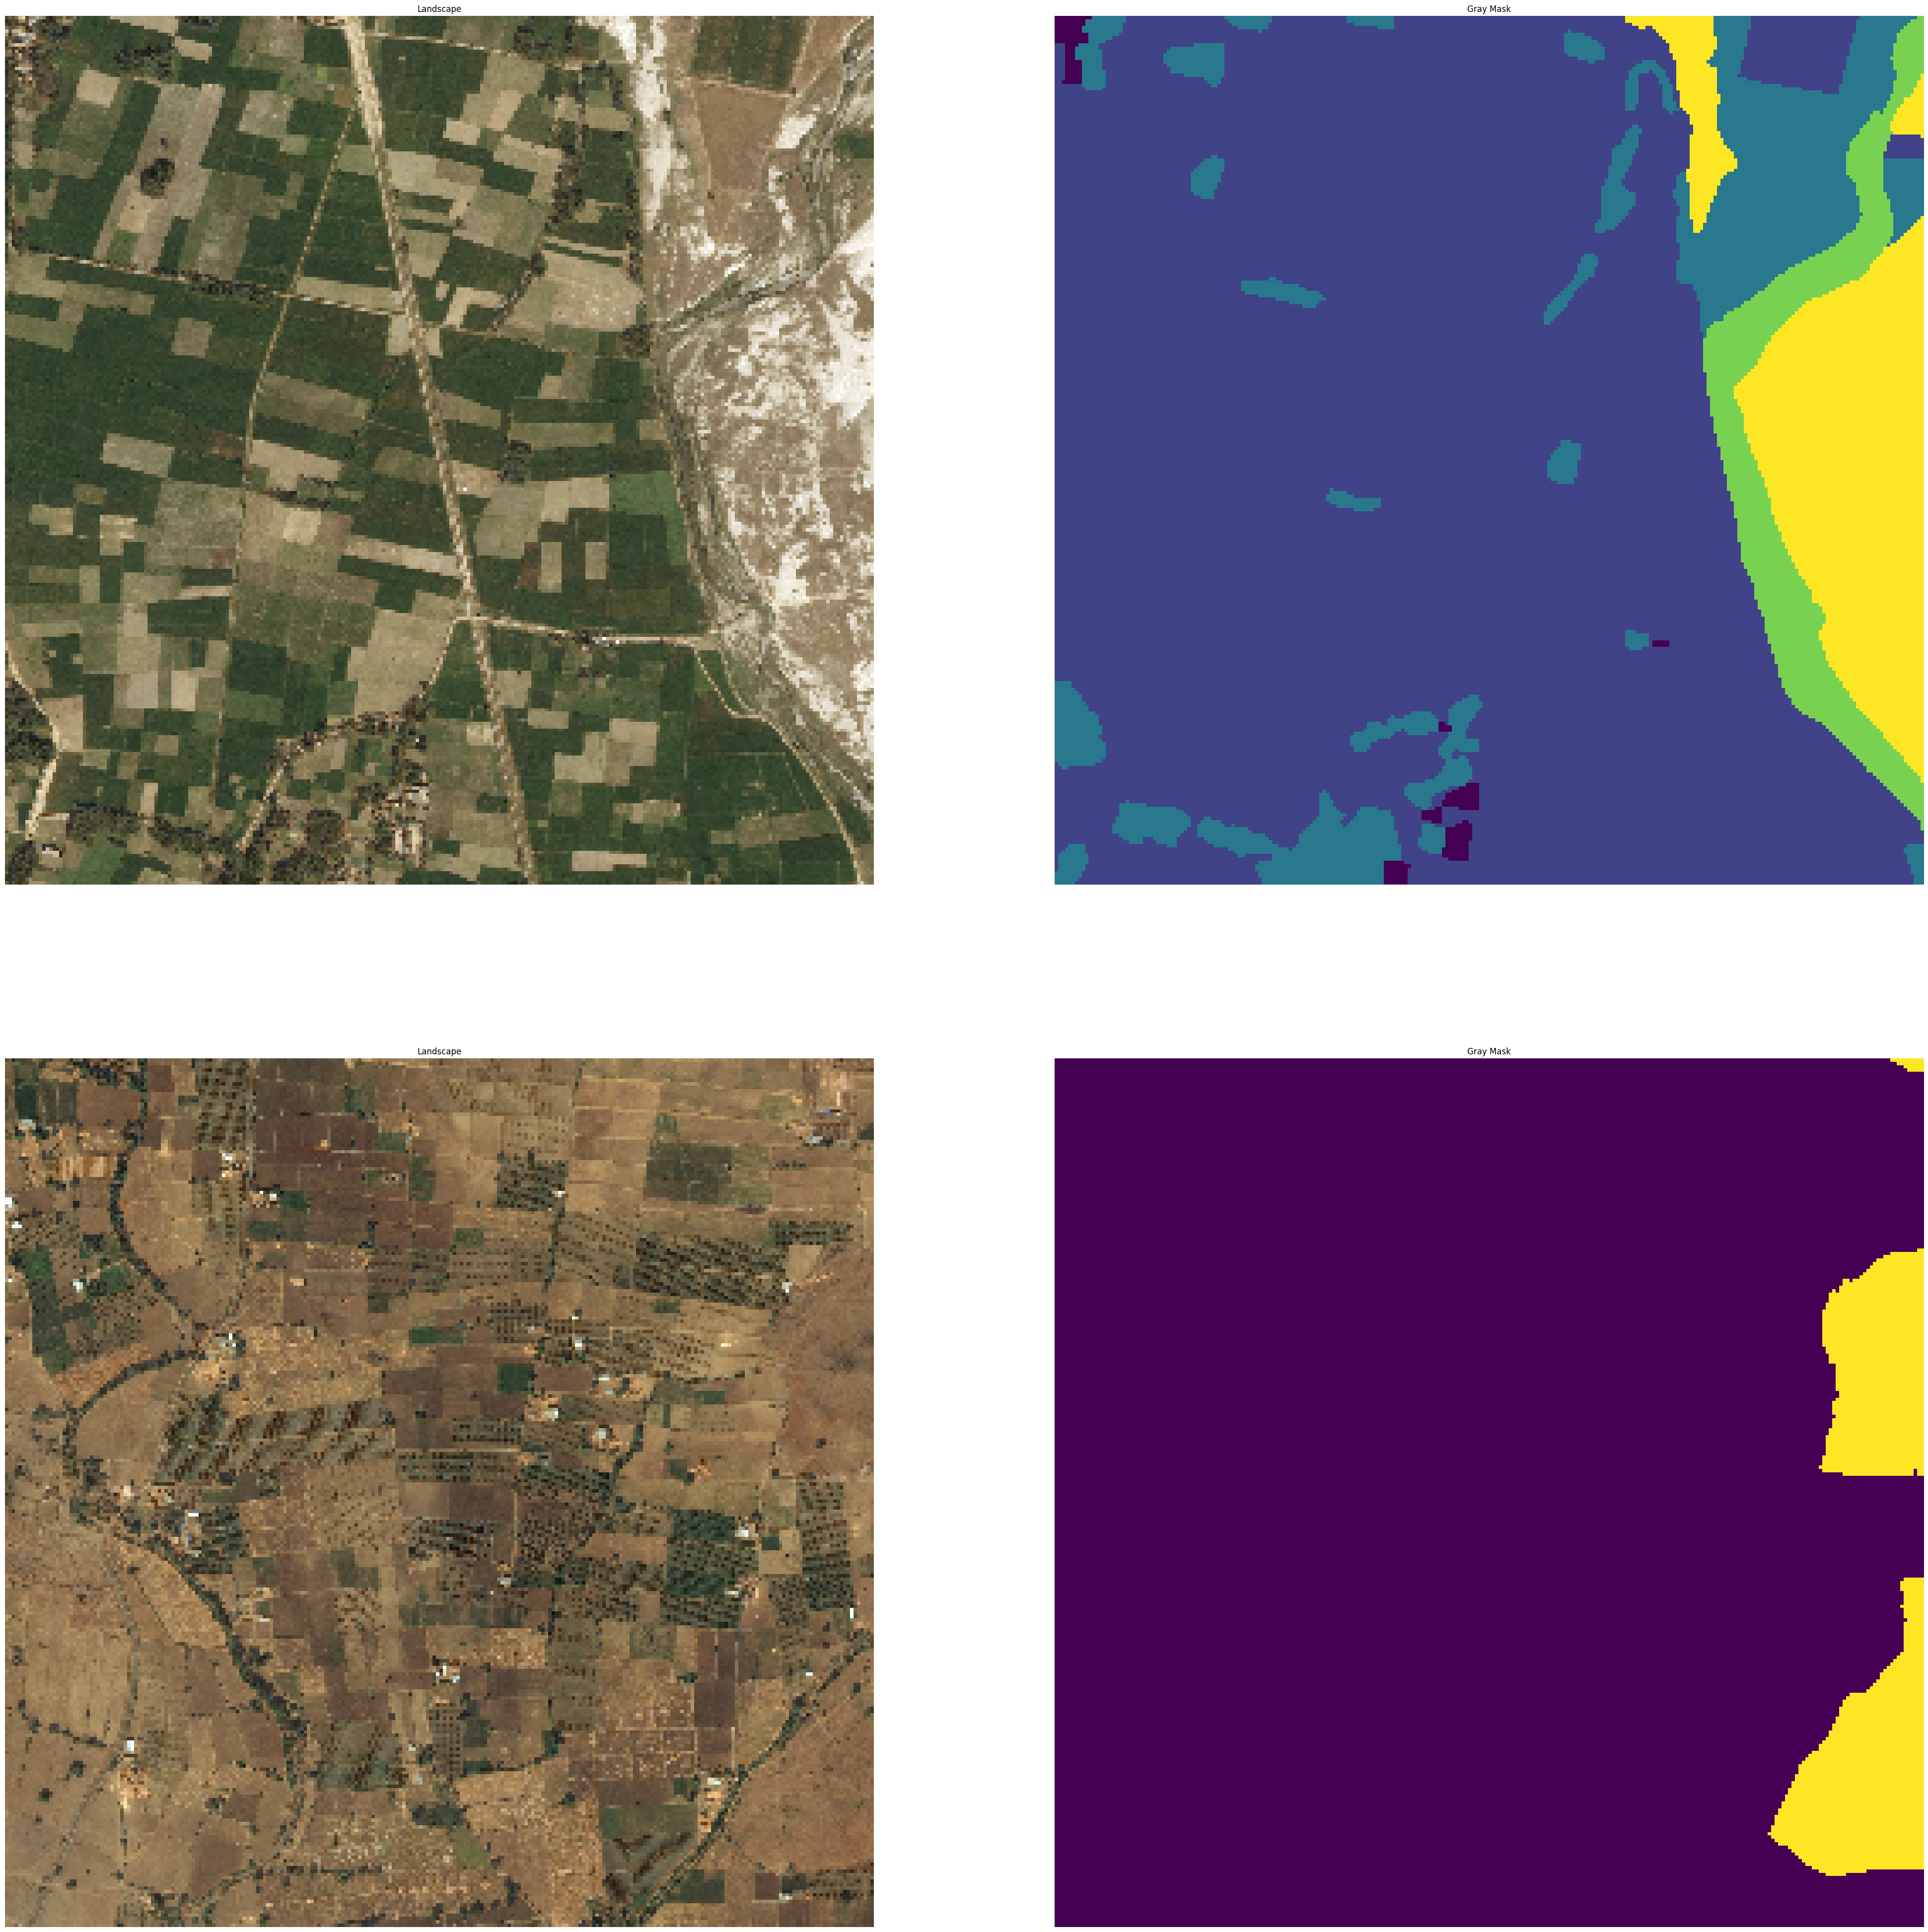

In [11]:
def check_gens(train_gen, valid_gen):
    x, y = next(train_gen)
    i =8
    plt.figure(figsize = (50,50))
    plt.subplot(221)
    plt.axis('off')
    plt.title('Landscape')
    plt.imshow(x[i])

    plt.subplot(222)
    plt.axis('off')
    plt.title('Gray Mask')
    plt.imshow(np.argmax((y)[i],axis=2)*64)


    x, y = next(valid_gen)
    plt.subplot(223)
    plt.axis('off')
    plt.title('Landscape')
    plt.imshow(x[i])

    plt.subplot(224)
    plt.axis('off')
    plt.title('Gray Mask')
    plt.imshow(np.argmax((y)[i],axis=2)*64)
    
check_gens(t,v)

In [12]:
reduce = ReduceLROnPlateau(
    monitor='val_iou_score',
    patience=2, 
    verbose=1, 
    mode='min', 
    min_delta=0.0001, 
    cooldown=2, 
    min_lr=1e-6
)

early = EarlyStopping(
    monitor="val_iou_score", 
    mode="min", 
    patience=2
)

callbacks = [reduce, early]

In [13]:
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(num_classes, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [16]:
model = unet()

model = sm.Unet(
    "vgg16", 
    encoder_weights='imagenet', 
    input_shape=(256, 256, 3),
    classes=num_classes, 
    activation='softmax'
)

model.compile(
    optimizer = Adam(learning_rate = 0.0001), 
    loss=sm.losses.jaccard_loss, 
    metrics=[sm.metrics.iou_score]
)

58889256/58889256 [==============================] - 2s 0us/step


In [17]:
history = model.fit(
    t,
    steps_per_epoch=5,
    epochs=EPOCHS, 
    validation_data=v, 
    validation_steps=5, 
    callbacks =callbacks
)

Epoch 1/5
5/5 [==============================] - 91s 18s/step - loss: 0.9394 - iou_score: 0.0554 - val_loss: 0.9554 - val_iou_score: 0.0459 - lr: 1.0000e-04
Epoch 2/5
5/5 [==============================] - 99s 21s/step - loss: 0.9330 - iou_score: 0.0670 - val_loss: 0.9526 - val_iou_score: 0.0471 - lr: 1.0000e-04
Epoch 3/5
5/5 [==============================] - 104s 22s/step - loss: 0.9251 - iou_score: 0.0749 - val_loss: 0.9568 - val_iou_score: 0.0447 - lr: 1.0000e-04
Epoch 4/5
5/5 [==============================] - 105s 22s/step - loss: 0.9159 - iou_score: 0.0841 - val_loss: 0.9588 - val_iou_score: 0.0412 - lr: 1.0000e-04
Epoch 5/5
5/5 [==============================] - 92s 20s/step - loss: 0.9162 - iou_score: 0.0838 - val_loss: 0.9474 - val_iou_score: 0.0545 - lr: 1.0000e-04
